In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import netCDF4 as nc4

import xarray as xr

In [10]:
pmm = "netcdf_files/eORCA1.4.2_ModifStraits_domain_cfg.nc"

mm = nc4.Dataset(pmm)
#
e3t_1d = mm.variables['e3t_1d'][0] ; e1t = mm.variables['e1t'][0] ; e2t = mm.variables['e2t'][0] 
# U-V facets
e3t_0 = mm.variables['e3t_0'][0] ; e3u_0 = mm.variables['e3u_0'][0]; e3v_0 = mm.variables['e3v_0'][0]
# partial cells
e3w_0 = mm.variables['e3w_0'][0] ; e3uw_0 = mm.variables['e3uw_0'][0] ; e3vw_0 = mm.variables['e3vw_0'][0]
e3w_1d = mm.variables['e3w_1d'][0]
#
botl = mm.variables['bottom_level'][0] # goes from 0 to 74 (75 levels)
bath = mm.variables['bathy_meter'][0] # goes from 0 to 74 (75 levels)
nK,nJ,nI = np.shape(e3w_0)

mm.close()

In [16]:
pmm = "netcdf_files/eORCA1.4.2_ModifStraits_mesh_mask.nc"
mm = nc4.Dataset(pmm)
#
gdept = mm.variables['gdept_0'][0] ; gdepw = mm.variables['gdepw_0'][0] ; botl = mm.variables['mbathy'][0]
# mbathy goes from 0 (land) to jpk-1 (74) - peut être qu'il est maské
# bottom_level goes from 1 (land) to jpk-1 (74) - same level as mbathy (Gibraltar = 34)
e3t_0 = mm.variables['e3t_0'][0] ; e3w_0 = mm.variables['e3w_0'][0]
e3t_1d = mm.variables['e3t_1d'][0]  ; e3w_1d = mm.variables['e3w_1d'][0] 
mm.close()

with open('protected_cells_230112.npy', 'rb') as f:
    protected_nodes = np.load(f)

In [17]:
ii,jj=protected_nodes[1700]
kk0 = botl[jj,ii]
print(kk0)

64


In [21]:
e3t_0[kk0  ,jj,ii]/e3t_1d[kk0]

0.973999803876693

In [14]:
print(gdepw[kk0+1,jj,ii] - gdepw[kk0  ,jj,ii])
print(gdept[kk0  ,jj,ii] - gdept[kk0-1,jj,ii])
print(gdepw[kk0+2,jj,ii] - gdepw[kk0+1,jj,ii])
print(gdept[kk0+1,jj,ii] - gdept[kk0  ,jj,ii])

189.2307140226676
189.2307140226676
196.01289157631163
195.17680429298161


In [13]:
print(e3t_0[kk0  ,jj,ii])
print(e3w_0[kk0  ,jj,ii])
print(e3t_0[kk0+1,jj,ii])
print(e3w_0[kk0+1,jj,ii])

189.2307140226676
189.2307140226676
196.01289157631163
195.17680429298161


In [11]:
print(gdepw[kk0  ,jj,ii])
print(gdept[kk0  ,jj,ii])
print(gdepw[kk0+1,jj,ii])
print(gdept[kk0+1,jj,ii])

3798.0
3892.360033164199
3987.2307140226676
4087.536837457181


---
### Read the protected cells

In [1]:
# https://mpl-point-clicker.readthedocs.io/en/latest/
palette = plt.get_cmap("terrain_r",75)
%matplotlib inline
fig, ax = plt.subplots(figsize=(9,9))
cf = plt.imshow(botl[::-1], cmap=palette)
fig.colorbar(cf,orientation="horizontal")
ax.set_aspect(aspect='equal')

try : 
    with open('protected_cells_230112.npy', 'rb') as f:
        protected_nodes = np.load(f)
    plt.scatter(protected_nodes[:,0],protected_nodes[:,1],color="k", s=2)
except :
    print("list not found")

# add zooming and middle click to pan

ax.patch.set_color('0.7')


plt.show()

NameError: name 'plt' is not defined

---
## 1) Partial cells penalised
Each levels are horizontally aligned. Evacuate the well-known associated with the terrain following coordinate. 

In [4]:
e3wp = np.copy(e3w_0)
for j in range(nJ):
    for i in range(nI):
        e3wp[:,j,i] = e3w_1d[:]    

In [32]:
# writing
ds=xr.open_dataset(pmm)
ds.e3w_0 [0]=e3wp
ds.e3uw_0[0]=e3wp
ds.e3vw_0[0]=e3wp

ds.to_netcdf("penalised_domain/eORCA1.4.2_ModifStraits_domain_cfg_bvp_e3wuwvw.nc") # rewrite to netcdf

---
## 2) Volume penalisation

### 2.1) Vertical integration

- For one column $(i,j)$ interpolate $b_{i,j}$ with the surrounding cells
  - if (i,j) is in the protected list, just skip it (as the partial cells alreay done)
  - coastlines cells unchanged below 10m
- Select vertically the vertically cells, find the intersections, plot it
- For each level, estimate (rectangular integration) the volume of water/land then save in the 3D array $\phi_t$

In [11]:
rpot = 0. * np.copy(e3t_0) # 3D array
zdep = np.cumsum(e3t_1d) # 75 niveau w(k) pour cellule T(k-1)

# bathf
bathf = np.copy(bath)
for j in range(1,nJ-1):
    for i in range(1,nI-1):
        bathf[j,i] = 0.25 * ( bath[j+1,i] + bath[j+1,i+1]   \
                            + bath[j  ,i] + bath[j  ,i+1] )

In [153]:
def isinset(a,b):
    flag = False
    with open('protected_cells.npy', 'rb') as f:
        protected_nodes = np.load(f)

    Ni,_ = np.shape(protected_nodes)
    for i in range(Ni):
        pn = protected_nodes[i]
        if np.allclose([a,b],pn):
            flag = True
            break
    return(flag)

masked_array(
  data=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  mask=False,
  fill_value=True)

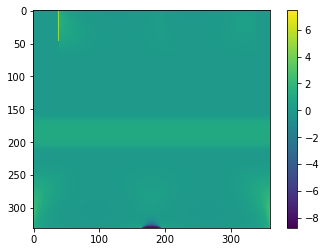

In [156]:
plt.imshow(np.log(e1t/e2t))
plt.colorbar()

In [188]:
lx/ly

2.9910815098534784

In [209]:
#ii = 269 ; jj = 261
ii = 200 ; jj = 180

""" Test if exception or near the coastline """
#if (jj,ii) in protected_list : 
#    continue
#
#if bath[jj,ii] < 10 :
#    continue

""" Build local basis """
#lx = e1t[jj,ii] ; ly = e2t[jj,ii] # e2u mean ? e1v mean ? à l'équateur très anistropque
lx = 1. ; ly = 1. 

Fz = np.array([bathf[jj-1,ii-1],
               bathf[jj-1,ii  ],
               bathf[jj  ,ii  ],
               bathf[jj  ,ii-1]])
Tz = bath [jj,ii]

Fx = np.array([-0.5, 0.5,0.5,-0.5]) * lx
Fy = np.array([-0.5,-0.5,0.5, 0.5]) * ly
Fc = ['royalblue','limegreen','orange','red']


xx = np.array([-0.5, 0.5,-0.5,0.5]) * lx
yy = np.array([-0.5,-0.5, 0.5,0.5]) * ly 

zz = np.array([bathf[jj-1,ii-1],
               bathf[jj-1,ii  ],
               bathf[jj  ,ii-1],
               bathf[jj  ,ii  ]])

#xx = [-0.5, 0.5,0.,-0.5,0.5]
#yy = [-0.5,-0.5,0., 0.5,0.5]
#zz = np.array([bathf[jj-1,ii-1],
#               bathf[jj-1,ii  ],
#               bath [jj  ,ii  ],
#               bathf[jj  ,ii-1],
#               bathf[jj  ,ii  ]])
from scipy import interpolate
#fz = interpolate.interp2d(Fx,Fy,Fz,kind='linear')
#tck = interpolate.bisplrep(xx,yy,zz,kx=1,ky=1)
fz = interpolate.bisplrep(xx,yy,zz,kx=1,ky=1)

#fz[0]/=lx ; fz[1]/=ly

""" Find the impacted cells """
kkm = np.argmin(np.abs(zdep-np.min(Fz)))
if zdep[kkm]>np.min(Fz) : kkm-=1

kkp = np.argmin(np.abs(zdep-np.max(Fz)))
if zdep[kkm]<np.max(Fz) and kkp <75 : kkp+=1
    
kk0 = botl[jj,ii]

In [210]:
fz

[array([-0.5, -0.5,  0.5,  0.5]),
 array([-0.5, -0.5,  0.5,  0.5]),
 array([3110.75, 2879.75, 2967.  , 2687.25]),
 1,
 1]

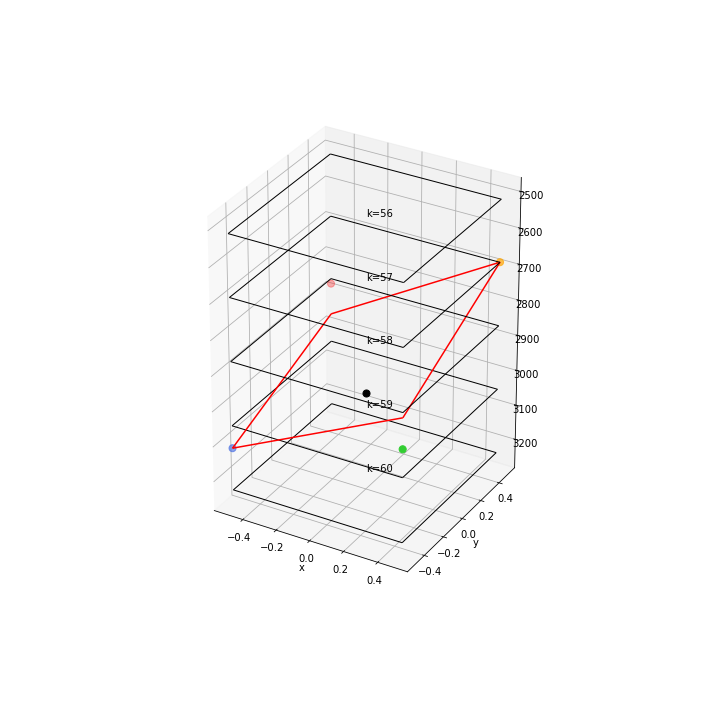

In [211]:
""" Visualisation """

%matplotlib inline
#matplotlib notebook
# https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

x = np.linspace(-0.5, 0.5, 2)*lx
y = np.linspace(-0.5, 0.5, 2)*ly
X, Y = np.meshgrid(x, y)                 
#Z = fz(x,y)
Z = interpolate.bisplev(x, y, fz)

x0,y0 = np.meshgrid(np.array([-0.5,0.5])*lx,
                    np.array([-0.5,0.5])*ly)
z0 = 0.*x0 + 1.

plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

from mpl_toolkits.mplot3d import Axes3D
scale_x = 0.5 ; scale_y = 0.5 ; scale_z = 1.
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([scale_x, scale_y, scale_z, 1]))

#ax.view_init(20,-30) # vertical (y rot - zx plan), horzontal (z rot - xy)
ax.scatter3D(Fx, Fy, Fz, c=Fc, s = 50)
ax.scatter3D(0., 0., Tz, c='k', s = 50)
ax.plot_wireframe(X, Y, Z, color='red')
#ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.invert_zaxis()

for k in range(kkm,kkp+1):
    ralpha = (k+1-kkm)/(kkp+1-kkm)
    #print(ralpha)
    ax.plot_wireframe(x0, y0, zdep[k]*z0, color='black',linewidth = 1)
    #ax.plot_surface(x0, y0, zdep[k]*z0, color='grey',alpha=ralpha)
    ax.text(0, 0, zdep[k], "k=%d" % (k), color='k')
plt.tight_layout()

#plt.close()
plt.show()

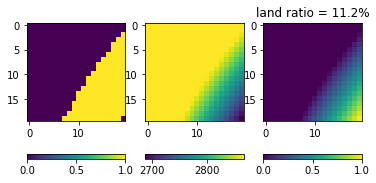

In [212]:
#for k in range(kkm,kkp):
k = kkm + 2
# maximum or minimum element wise # je veux être "plus bas" que (k-1) mais plus haut que (k)
fk = lambda x,y : np.maximum( zdep[k-1], np.minimum( zdep[k], interpolate.bisplev(x, y, fz) ))
# >0 == terre
fk_nor = lambda x,y : (zdep[k]-fk(x,y))/(zdep[k]-zdep[k-1])


nx = 20 ; ny = 20
x = np.linspace(-0.5, 0.5, nx) * lx
y = np.linspace(-0.5, 0.5, ny) * ly            

Z_nor = fk_nor(x,y)

# integrate with rectangle rule # suppose uniform grid first
r_land = np.sum(Z_nor)/(nx*ny)
#rpot[k,j,i] = 1 - r_land

Z  = interpolate.bisplev(x, y, fz)
Zk = fk(x,y)

fig, ax = plt.subplots(1,3)
plt.title("land ratio = {0:.1%}".format(r_land))
a1 = ax[0].imshow((Z>zdep[k-1]) * (Z<zdep[k]))
a2 = ax[1].imshow(Zk, vmin = zdep[k-1], vmax = zdep[k])
a3 = ax[2].imshow(Z_nor,vmin=0,vmax=1)

fig.colorbar(a1, ax=ax[0:1], location='bottom')
fig.colorbar(a2, ax=ax[1:2], location='bottom')
fig.colorbar(a3, ax=ax[2:3], location='bottom')

---
### 2.2) U-V facets penalised - useless without bulk penalisation
The first steps is to penalised the speed (U,V) facets. Calculating the penalisation for T cells is too big for a first change. Water column remains unchanged but topographic inclination stays untouched. A penalised facet is the section defined encompassed between the above edge and the bathymetry, meaned at the speed node:

$$ \phi_u^{i,j}(k) = \frac{1}{2}\frac{b_t^{i,j} + b_t^{i+1,j}}{gdep_w^u(k)} \quad\quad (i1) $$


$$ e_{3u}^{i,j}(k) = \frac{1}{2}(e_{3t}^{i,j} + e_{3t}^{i+1,j}) \quad\quad (i1) $$


Smoothing the bathymetry may have the effect to enforce topostrophy although decreasing the slope. Spreading the slope around a few grid points may help the model to solve it:

$$ \phi_u^{i,j}(k) = \frac{1}{2}\frac{\overline{\overline{b_t}}^{i,j} + \overline{\overline{b_t}}^{i,j-1}}{gdep_w^u(k)} \quad\quad (i2) $$ 
$$ e_{3u}^{i,j}(k) = \frac{1}{2}(e_{3f}^{i,j} + e_{3f}^{i,j+1}) \quad \text{where} \quad e_{3f}^{i,j} = \frac{1}{4} (e_{3t}^{i,j}+e_{3t}^{i+1,j}+e_{3t}^{i,j+1}+e_{3t}^{i+1,j+1})\quad  \quad\quad (i2) $$ 

In [5]:
# "partial-cells"
e3wp = np.copy(e3w_0)
for j in range(nJ):
    for i in range(nI):
        e3wp[:,j,i] = e3w_1d[:]    

In [6]:
# (i) penalisation # need to change U depth as well -> non
e3up = np.copy(e3u_0) ; e3vp = np.copy(e3v_0)
for j in range(1,nJ-1):
    for i in range(1,nI-1):
        e3up[:,j,i] = 0.5 * ( e3t_0[:,j  ,i+1] + e3t_0[:,j,i] )
        e3vp[:,j,i] = 0.5 * ( e3t_0[:,j+1,i  ] + e3t_0[:,j,i] )

In [28]:
#plt.figure(figsize=(18,8))
#plt.imshow(e3up[:,:,180])
#plt.colorbar() 

In [7]:
# writing
ds=xr.open_dataset(pmm)
ds.e3w_0 [0]=e3wp
ds.e3uw_0[0]=e3wp
ds.e3vw_0[0]=e3wp

ds.e3u_0[0]=e3up
ds.e3v_0[0]=e3vp

ds.to_netcdf("penalised_domain/eORCA1.4.2_ModifStraits_domain_cfg_bvp_e3w_e3uv.nc") # rewrite to netcdf

-----

In [9]:
# (ii) penalisation
e3fp = np.copy(e3t_0)
for j in range(1,nJ-1):
    for i in range(1,nI-1):
        e3fp[:,j,i] = 0.25 * ( e3t_0[:,j+1,i] + e3t_0[:,j+1,i+1]   \
                             + e3t_0[:,j  ,i] + e3t_0[:,j  ,i+1] )
                              
e3up = np.copy(e3u_0) ; e3vp = np.copy(e3v_0)
for j in range(1,nJ-1):
    for i in range(1,nI-1):
        e3up[:,j,i] = 0.5 * ( e3fp[:,j+1,i  ] + e3fp[:,j,i] ) # moyenne j
        e3vp[:,j,i] = 0.5 * ( e3fp[:,j  ,i+1] + e3fp[:,j,i] ) # moyenne i

In [10]:
# writing
ds=xr.open_dataset(pmm)
ds.e3w_0 [0]=e3wp
ds.e3uw_0[0]=e3wp
ds.e3vw_0[0]=e3wp

ds.e3u_0[0]=e3up
ds.e3v_0[0]=e3vp

ds.to_netcdf("penalised_domain/eORCA1.4.2_ModifStraits_domain_cfg_bvp_e3w_e3uvi2.nc") # rewrite to netcdf